# Challenge Data ENS : Return Forecasting of Cryptocurrency Clusters (par Napoleon X)

---

## 1. Packages et paramètres

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import networkx as nx

# modélisation
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import skew, kurtosis
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# paramètres de style pour les graphiques
plt.style.use("dark_background")

plt.rcParams.update({
    "grid.color": "#444444",
    "grid.alpha": 0.8,
    "grid.linestyle": "--", 
})

---

## 2. Data

### 2.1 Importation des données

In [65]:
x_train = pd.read_csv('input/input_train__fppJZ22.csv')
y_train = pd.read_csv('input/y_train_CGZ7jXu.csv')
x_test = pd.read_csv('input/input_test__2scdXsn.csv')
    
print("Taille de x_train :", x_train.shape)
print("Taille de y_train :", y_train.shape)

display(x_train.head(), y_train.head())

# Import de la matrice d'adjacence
with open("input/adjacency_matrices_pgWTvf5.pkl", "rb") as file:
    adj = pickle.load(file)

Taille de x_train : (491038, 29)
Taille de y_train : (30494, 2)


id  cluster  day  asset        md        bc     ret_1     ret_2     ret_3  \
0   0        0   17     10 -5.734573  0.125855 -0.002060  0.005848 -0.002736   
1   1        0    0     13 -5.813696  0.418711 -0.042280 -0.009460 -0.005173   
2   2        0   20     12 -5.814399  0.500111  0.003665 -0.010841  0.007557   
3   3        0   19     12 -5.814399  0.500111 -0.018364  0.003789  0.011795   
4   4        0   18     12 -5.814399  0.500111 -0.001589  0.011711 -0.010507   

      ret_4  ...    ret_14    ret_15    ret_16    ret_17    ret_18    ret_19  \
0 -0.005487  ...       NaN -0.000339  0.001018 -0.002372 -0.000340 -0.000680   
1 -0.006000  ...  0.004107 -0.005726  0.006993 -0.003268  0.015574 -0.010492   
2  0.004981  ... -0.000113 -0.000170 -0.002833 -0.007442 -0.001832 -0.005677   
3  0.016029  ...  0.005604 -0.009794 -0.001023 -0.002959  0.002568 -0.005579   
4 -0.002555  ...  0.002530 -0.018505 -0.010855  0.002022  0.001211 -0.002648   

     ret_20    ret_21    ret_22    ret_23  
0 -0.007140  0.006849  0.002041 -0.001697  
1  0.004486  0.011368  0.001606  0.000401  
2 -0.007093  0.001626  0.004349 -0.004677  
3  0.001317 -0.010005  0.004677 -0.004196  
4  0.001559 -0.001153  0.000635  0.001961  

[5 rows x 29 columns]

sample_id    target
0          0  0.000301
1          1 -0.011966
2          2 -0.011395
3          3  0.000664
4          4  0.002852

### 2.2 Valeurs manquantes

In [66]:
missing_values_df = x_train.isnull().sum().reset_index()
missing_values_df.columns = ['Feature', 'Missing Values']
missing_values_df = missing_values_df[missing_values_df['Missing Values'] > 0]
missing_values_df = missing_values_df.sort_values(by='Missing Values', ascending=False).reset_index(drop=True)
display(missing_values_df)

Feature  Missing Values
0   ret_20           28373
1   ret_19           28310
2    ret_4           28007
3   ret_21           27984
4   ret_22           27890
5    ret_6           27556
6    ret_7           26963
7   ret_18           26867
8    ret_5           26834
9   ret_23           26706
10  ret_10           26644
11   ret_3           26422
12  ret_11           25931
13   ret_8           25770
14   ret_2           25652
15  ret_12           25367
16   ret_9           25311
17  ret_13           24933
18  ret_14           24812
19  ret_16           24348
20  ret_15           24019
21  ret_17           23977
22   ret_1           23869
23      bc            1092

In [67]:
ret_cols = [f'ret_{i}' for i in range(1, 24)]

# Imputation des valeurs manquantes par interpolation linéaire
x_train.loc[:, ret_cols] = x_train.loc[:, ret_cols].T.interpolate(method='linear').T
x_test.loc[:, ret_cols] = x_test.loc[:, ret_cols].T.interpolate(method='linear').T

# Fallback : imputation par la médiane du cluster-jour
x_train.loc[:, ret_cols] = x_train.loc[:, ret_cols].fillna(
    x_train.groupby(['cluster', 'day'])[ret_cols].transform('median')
)
x_test.loc[:, ret_cols] = x_test.loc[:, ret_cols].fillna(
    x_test.groupby(['cluster', 'day'])[ret_cols].transform('median')
)

# Imputation des valeurs manquantes pour la colonne 'bc' par la médiane du cluster-jour
x_train['bc'] = x_train['bc'].fillna(
    x_train.groupby(['cluster', 'day'])['bc'].transform('median')
)
x_test['bc'] = x_test['bc'].fillna(
    x_test.groupby(['cluster', 'day'])['bc'].transform('median')
)

### 2.3 Features structurelles

**Le Cluster comme un Réseau :**

* Nous considérons chaque cluster comme un **graphe** :
    * Chaque **actif** ($A_i$) est un **nœud** (ou sommet).
    * Chaque $\mathbf{A}_{ij} = 1$ signale un **lien de co-mouvement très significatif** entre les actifs $i$ et $j$ (une arête).
* L'objectif est de quantifier l'**influence** et la **position** de chaque actif dans ce réseau.

**Les Métriques de Centralité Clés :**

Nous utilisons la librairie `networkx` pour calculer les métriques suivantes qui traduisent l'importance structurelle de chaque actif :

* **Le Degré du Nœud (`Degree Centrality`)**
    * Il compte le **nombre de connexions directes** qu'un actif possède.
    * **Rôle :** Un degré élevé identifie un **actif central** ou "populaire", dont le comportement est fortement corrélé à celui de nombreux autres.

* **La Centralité du Vecteur Propre (`Eigenvector Centrality`)**
    * Elle mesure l'influence d'un actif en fonction de l'importance de **ses voisins**.
    * **Rôle :** Elle identifie les **leaders stratégiques**. Un actif est influent s'il est connecté à d'autres actifs qui sont eux-mêmes très influents.

* **La Centralité d'Intermédiarité (`Betweenness Centrality`)**
    * Elle quantifie la fréquence à laquelle un actif se trouve sur le **chemin le plus court** entre deux autres actifs.
    * **Rôle :** Un actif avec une forte intermédiarité agit comme un **pont** ou un **intermédiaire** crucial pour la propagation de la dynamique à travers le cluster.

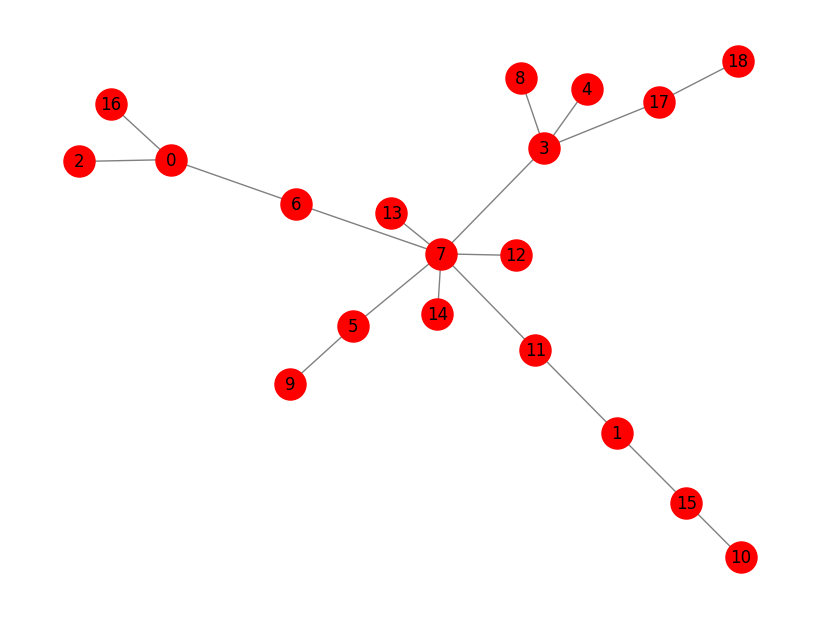

In [68]:
# exemple de visualisation du graphe pour le cluster 0
g = nx.from_numpy_array(adj[0])
pos = nx.spring_layout(g, seed=42)
plt.figure(figsize=(8, 6))
nx.draw(g, pos=pos, with_labels=True, node_color='red', edge_color='gray', node_size=500)
plt.show()

In [69]:
def calculate_graph_features(df, adj_dict):
    df['node_degree'] = np.nan
    df['eigen_centrality'] = np.nan
    df['betweenness_centrality'] = np.nan
    
    # Boucler sur chaque cluster unique présent dans les données d'entraînement
    for cluster_id, cluster_df in df.groupby('cluster'):
        if cluster_id in adj_dict:
            # Récupérer la matrice d'adjacence pour ce cluster
            A = adj_dict[cluster_id]
            # Créer le graphe networkx
            G = nx.from_numpy_array(A)
            
            # Calculer les métriques
            degree = dict(G.degree())
            eigen_centrality = nx.eigenvector_centrality(G, max_iter=1000)
            betweenness_centrality = nx.betweenness_centrality(G)
            
            # Appliquer les résultats au DataFrame original (en utilisant l'index 'asset')
            # L'index 'asset' (0, 1, 2...) correspond ici aux indices des nœuds du graphe.
            node_map = cluster_df['asset'].unique() 
            
            for i, asset_id in enumerate(node_map):
                df.loc[cluster_df[cluster_df['asset'] == asset_id].index, 'node_degree'] = degree[i]
                df.loc[cluster_df[cluster_df['asset'] == asset_id].index, 'eigen_centrality'] = eigen_centrality[i]
                df.loc[cluster_df[cluster_df['asset'] == asset_id].index, 'betweenness_centrality'] = betweenness_centrality[i]

    return df

# xtrain
x_train_2 = calculate_graph_features(x_train, adj)

# xtest
x_test_2 = calculate_graph_features(x_test, adj)

# aperçu des nouvelles features
display(x_train_2[['cluster','day', 'asset', 'node_degree', 'eigen_centrality', 'betweenness_centrality']].head(10))

cluster  day  asset  node_degree  eigen_centrality  betweenness_centrality
0        0   17     10          3.0          0.124844                0.215686
1        0    0     13          2.0          0.106924                0.209150
2        0   20     12          1.0          0.043783                0.000000
3        0   19     12          1.0          0.043783                0.000000
4        0   18     12          1.0          0.043783                0.000000
5        0   17     12          1.0          0.043783                0.000000
6        0   16     12          1.0          0.043783                0.000000
7        0   15     12          1.0          0.043783                0.000000
8        0   14     12          1.0          0.043783                0.000000
9        0   13     12          1.0          0.043783                0.000000

### 2.4 Features temporelles

In [70]:
ret_cols = [f'ret_{i}' for i in range(1, 24)]
last_ret = ['ret_21', 'ret_22', 'ret_23']

x_train_3 = x_train_2.copy()
x_test_3 = x_test_2.copy()

# tendance
x_train_3['ret_sum'] = x_train_2[ret_cols].sum(axis=1)
x_train_3['ret_mean'] = x_train_2[ret_cols].mean(axis=1)
x_train_3['ret_recent_mean'] = x_train_2[last_ret].mean(axis=1)
x_test_3['ret_sum'] = x_test_2[ret_cols].sum(axis=1)
x_test_3['ret_mean'] = x_test_2[ret_cols].mean(axis=1)
x_test_3['ret_recent_mean'] = x_test_2[last_ret].mean(axis=1)

# volatilité et risque
x_train_3['ret_std'] = x_train_2[ret_cols].std(axis=1)
x_train_3['ret_recent_std'] = x_train_2[last_ret].std(axis=1)
x_train_3['ret_max_abs'] = x_train_2[ret_cols].abs().max(axis=1)
x_train_3['ret_diff_start_end'] = x_train_2['ret_23'] - x_train_2['ret_1']
x_test_3['ret_std'] = x_test_2[ret_cols].std(axis=1)
x_test_3['ret_recent_std'] = x_test_2[last_ret].std(axis=1)
x_test_3['ret_max_abs'] = x_test_2[ret_cols].abs().max(axis=1)
x_test_3['ret_diff_start_end'] = x_test_2['ret_23'] - x_test_2['ret_1']


# forme de distribution (optimisation clé)
ret_values = x_train_2[ret_cols].values
x_train_3['ret_kurtosis'] = kurtosis(ret_values, axis=1, fisher=True)
x_train_3['ret_skew'] = skew(ret_values, axis=1)
ret_values = x_test_2[ret_cols].values
x_test_3['ret_kurtosis'] = kurtosis(ret_values, axis=1, fisher=True)
x_test_3['ret_skew'] = skew(ret_values, axis=1)

# affichage des données finales
print("Features temporelles et de risque ajoutées à x_train.")
print(x_train_3.columns)
display(x_train_3.head())

Features temporelles et de risque ajoutées à x_train.
Index(['id', 'cluster', 'day', 'asset', 'md', 'bc', 'ret_1', 'ret_2', 'ret_3',
       'ret_4', 'ret_5', 'ret_6', 'ret_7', 'ret_8', 'ret_9', 'ret_10',
       'ret_11', 'ret_12', 'ret_13', 'ret_14', 'ret_15', 'ret_16', 'ret_17',
       'ret_18', 'ret_19', 'ret_20', 'ret_21', 'ret_22', 'ret_23',
       'node_degree', 'eigen_centrality', 'betweenness_centrality', 'ret_sum',
       'ret_mean', 'ret_recent_mean', 'ret_std', 'ret_recent_std',
       'ret_max_abs', 'ret_diff_start_end', 'ret_kurtosis', 'ret_skew'],
      dtype='object')


id  cluster  day  asset        md        bc     ret_1     ret_2     ret_3  \
0   0        0   17     10 -5.734573  0.125855 -0.002060  0.005848 -0.002736   
1   1        0    0     13 -5.813696  0.418711 -0.042280 -0.009460 -0.005173   
2   2        0   20     12 -5.814399  0.500111  0.003665 -0.010841  0.007557   
3   3        0   19     12 -5.814399  0.500111 -0.018364  0.003789  0.011795   
4   4        0   18     12 -5.814399  0.500111 -0.001589  0.011711 -0.010507   

      ret_4  ...  betweenness_centrality   ret_sum  ret_mean  ret_recent_mean  \
0 -0.005487  ...                0.215686  0.013948  0.000606         0.002398   
1 -0.006000  ...                0.209150 -0.057649 -0.002506         0.004458   
2  0.004981  ...                0.000000 -0.012499 -0.000543         0.000433   
3  0.016029  ...                0.000000  0.007558  0.000329        -0.003174   
4 -0.002555  ...                0.000000 -0.013068 -0.000568         0.000481   

    ret_std  ret_recent_std  ret_max_abs  ret_diff_start_end  ret_kurtosis  \
0  0.006418        0.004284     0.017845            0.000363      1.311102   
1  0.012580        0.006014     0.042280            0.042681      2.572392   
2  0.005645        0.004630     0.011399           -0.008342     -0.764790   
3  0.008430        0.007394     0.018384            0.014168      0.174211   
4  0.008918        0.001562     0.022431            0.003550      0.600029   

   ret_skew  
0  0.285072  
1 -1.427823  
2  0.108252  
3  0.177913  
4  0.339542  

[5 rows x 41 columns]

### 2.5 Aggrégation des données

* **Objectif :** Nous devons transformer les données de la granularité **Actif** à la granularité **Échantillon** ($\text{cluster} + \text{day}$) pour correspondre au format de $\mathbf{y}\_\text{train}$.
    > La formule : $\text{sample\_id} = \text{cluster} \times 21 + \text{day}$

* **Stratégie d'Agrégation Différenciée :** L'agrégation est essentielle pour ne pas perdre l'information structurelle. Nous utilisons deux méthodes principales :

**Agrégation Pondérée (Rendements)**

* **Features concernées :** Rendements horaires ($\mathbf{ret}_1$ à $\mathbf{ret}_{23}$) et moyennes/sommes de rendements.
* **Méthode :** Nous utilisons l'**`eigenvector_centrality`** (Centralité du Vecteur Propre) comme **poids** pour calculer une **moyenne pondérée**.
* **Rôle :** Cette méthode garantit que le signal de prédiction du cluster est dominé par les actifs les plus **influents** (les leaders du marché), car ils sont les plus pertinents pour le mouvement de groupe.

**Agrégation Statistique (Volatilité et Structure)**

* **Features concernées :** Volatilité ($\text{ret\_std}$), risque, et métriques de centralité ($\text{node\_degree}$, $\text{kurtosis}$, etc.).
* **Méthode :** Nous synthétisons la distribution des propriétés des actifs au sein du cluster :
    * **Moyenne simple (ou Médiane) :** Pour donner une valeur centrale typique.
    * **Écart-type ($\text{Std Dev}$) :** Pour mesurer l'**hétérogénéité** (la diversité du risque ou de la centralité) au sein du cluster.
    * **Maximum et Minimum ($\text{Max/Min}$) :** Pour capturer les **risques extrêmes** et identifier le degré de centralité le plus élevé.

In [71]:
# -- x_train ---

# Colonnes à aggréger pondérément par la centralité
TREND_COLS = ['ret_1', 'ret_2', 'ret_3', 'ret_4', 'ret_5', 'ret_6', 'ret_7', 'ret_8', 'ret_9', 'ret_10',
    'ret_11', 'ret_12', 'ret_13', 'ret_14', 'ret_15', 'ret_16', 'ret_17', 'ret_18', 'ret_19',
    'ret_20', 'ret_21', 'ret_22', 'ret_23', 'ret_sum', 'ret_mean', 'ret_recent_mean', 
    'ret_diff_start_end']

# Colonnes à agréger avec des statistiques descriptives
RISK_STRUCT_COLS = [
    'md', 'bc', 'node_degree', 'betweenness_centrality', 
    'ret_std', 'ret_recent_std', 'ret_max_abs', 
    'ret_kurtosis', 'ret_skew']

for col in TREND_COLS:
    x_train_3[f'{col}_weighted'] = x_train_3[col] * x_train_3['eigen_centrality']

agg_funcs = {
    **{f'{col}_weighted': 'sum' for col in TREND_COLS},
    'eigen_centrality': 'sum', 
    **{col: ['mean', 'std', 'max', 'min', 'median'] for col in RISK_STRUCT_COLS}
}

x_train_agg = x_train_3.groupby(['cluster', 'day']).agg(agg_funcs)

x_train_agg.columns = ['_'.join(col).strip() for col in x_train_agg.columns.values]
x_train_agg = x_train_agg.reset_index()

# Calcul de la moyenne pondérée finale : Numérateur / Dénominateur pour les colonnes de TREND_COLS
for col in TREND_COLS:
    numerator_col = f'{col}_weighted_sum'
    x_train_agg[f'{col}_weighted_mean'] = x_train_agg[numerator_col] / x_train_agg['eigen_centrality_sum']
    x_train_agg = x_train_agg.drop(columns=[numerator_col]) 

x_train_agg = x_train_agg.rename(columns={'eigen_centrality_sum': 'total_centrality_sum'})

x_train_agg['sample_id'] = x_train_agg['cluster'] * 21 + x_train_agg['day']
x_train_final = x_train_agg.drop(columns=['cluster', 'day'])
x_train_final = x_train_final.drop(columns=['id', 'asset'], errors='ignore')

cols = x_train_final.columns.tolist()
cols.insert(0, cols.pop(cols.index('sample_id')))
x_train_final = x_train_final[cols]

print(len(x_train_final))
display(x_train_final.tail(10))

# --- x_test ---

for col in TREND_COLS:
    x_test_3[f'{col}_weighted'] = x_test_3[col] * x_test_3['eigen_centrality']  

agg_funcs = {
    **{f'{col}_weighted': 'sum' for col in TREND_COLS},
    'eigen_centrality': 'sum', 
    **{col: ['mean', 'std', 'max', 'min', 'median'] for col in RISK_STRUCT_COLS}
}

x_test_agg = x_test_3.groupby(['cluster', 'day']).agg(agg_funcs)

x_test_agg.columns = ['_'.join(col).strip() for col in x_test_agg.columns.values]
x_test_agg = x_test_agg.reset_index()

# Calcul de la moyenne pondérée finale : Numérateur / Dénominateur pour les colonnes de TREND_COLS
for col in TREND_COLS:
    numerator_col = f'{col}_weighted_sum'
    denominator_col = 'eigen_centrality_sum'    
    x_test_agg[f'{col}_weighted_mean'] = x_test_agg[numerator_col] / x_test_agg[denominator_col]
    x_test_agg = x_test_agg.drop(columns=[numerator_col])

x_test_agg = x_test_agg.rename(columns={'eigen_centrality_sum': 'total_centrality_sum'})

x_test_agg['sample_id'] = x_test_agg['cluster'] * 21 + x_test_agg['day']
x_test_final = x_test_agg.drop(columns=['cluster', 'day'])
x_test_final = x_test_final.drop(columns=['id', 'asset'], errors='ignore')

cols = x_test_final.columns.tolist()
cols.insert(0, cols.pop(cols.index('sample_id')))
x_test_final = x_test_final[cols]

30494


sample_id  total_centrality_sum   md_mean    md_std    md_max  \
30484      30734              2.312814 -6.751337  1.651018 -4.214598   
30485      30735              2.312814 -6.751337  1.651018 -4.214598   
30486      30736              2.312814 -6.751337  1.651018 -4.214598   
30487      30737              2.312814 -6.751337  1.651018 -4.214598   
30488      30738              2.312814 -6.751337  1.651018 -4.214598   
30489      30739              2.312814 -6.751337  1.651018 -4.214598   
30490      30740              2.312814 -6.751337  1.651018 -4.214598   
30491      30741              2.312814 -6.751337  1.651018 -4.214598   
30492      30742              2.312814 -6.751337  1.651018 -4.214598   
30493      30743              2.312814 -6.751337  1.651018 -4.214598   

         md_min  md_median   bc_mean    bc_std    bc_max  ...  \
30484 -8.447019  -6.976589  0.471494  0.181586  0.634066  ...   
30485 -8.447019  -6.976589  0.471494  0.181586  0.634066  ...   
30486 -8.447019  -6.976589  0.471494  0.181586  0.634066  ...   
30487 -8.447019  -6.976589  0.471494  0.181586  0.634066  ...   
30488 -8.447019  -6.976589  0.471494  0.181586  0.634066  ...   
30489 -8.447019  -6.976589  0.471494  0.181586  0.634066  ...   
30490 -8.447019  -6.976589  0.471494  0.181586  0.634066  ...   
30491 -8.447019  -6.976589  0.471494  0.181586  0.634066  ...   
30492 -8.447019  -6.976589  0.471494  0.181586  0.634066  ...   
30493 -8.447019  -6.976589  0.471494  0.181586  0.634066  ...   

       ret_18_weighted_mean  ret_19_weighted_mean  ret_20_weighted_mean  \
30484         -6.500235e-03              0.004281              0.005718   
30485         -2.677349e-03              0.026991              0.016029   
30486          1.084745e-02              0.007082              0.021189   
30487          8.693990e-03              0.005143             -0.001994   
30488          1.177221e-02              0.002064             -0.007467   
30489         -5.354523e-07             -0.001402              0.003960   
30490         -8.567922e-04             -0.005075             -0.007698   
30491          4.957349e-03              0.005842              0.026345   
30492          1.745312e-03             -0.000679              0.003065   
30493         -3.431040e-05             -0.002402              0.008416   

       ret_21_weighted_mean  ret_22_weighted_mean  ret_23_weighted_mean  \
30484             -0.009034              0.016939              0.023750   
30485             -0.015080             -0.001480              0.010598   
30486              0.012279             -0.022552              0.006165   
30487             -0.007928             -0.003193              0.015412   
30488             -0.003995             -0.000287             -0.013009   
30489              0.013650              0.014763             -0.005937   
30490              0.008909             -0.009782             -0.006606   
30491              0.005196              0.005375             -0.004639   
30492             -0.006980             -0.005149             -0.001753   
30493             -0.010385             -0.002160              0.006147   

       ret_sum_weighted_mean  ret_mean_weighted_mean  \
30484               0.052840                0.002297   
30485               0.036690                0.001595   
30486               0.005583                0.000243   
30487               0.026113                0.001135   
30488              -0.023898               -0.001039   
30489              -0.054584               -0.002373   
30490              -0.018084               -0.000786   
30491               0.061316                0.002666   
30492              -0.009802               -0.000426   
30493               0.001548                0.000067   

       ret_recent_mean_weighted_mean  ret_diff_start_end_weighted_mean  
30484                       0.010552                          0.017414  
30485                      -0.001987                          0.019528  
30486     

---

## 3. Modèles

### 3.1 Méhtodologie

Le modèle est entraîné sur **x_train** et **y_train**, qui constituent le **Within-Sample (WS)**, c’est-à-dire les données utilisées pour ajuster les paramètres et apprendre les éventuels patterns. 

On réserve **x_test** comme **Out-Of-Sample (OOS)**, un jeu de données jamais vu par le modèle, pour évaluer sa capacité de généralisation. 

Les performances WS servent à contrôler l’apprentissage et à ajuster les hyperparamètres, tandis que les prédictions OOS permettent de mesurer la robustesse du modèle sur de nouvelles observations, sans risque de **data leakage**.

La métrique RMSE sur les données out of sample n'est donnée qu'un fois la soumission des résultats réalisée sur le site https://challengedata.ens.fr/participants/challenges/71

### 3.2 Random Forest Regressor

In [ ]:
X = x_train_final.drop(['sample_id'], axis=1)
Y = y_train['target']

model_rf = RandomForestRegressor(random_state=42)
tscv = TimeSeriesSplit(n_splits=2)

param_grid_rf = {
    'n_estimators': [200, 400, 600],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.75],
}

random_cv_rf = RandomizedSearchCV(
    estimator=model_rf,
    param_distributions=param_grid_rf,
    n_iter=50,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=0,
    random_state=42,
    return_train_score=True
)

random_cv_rf.fit(X, Y)

In [ ]:
print("----- Résultats du modèle Random Forest -----")
print(f"Meilleur score RMSE: {-random_cv_rf.best_score_:.8f}")
print("Meilleurs paramètres:", random_cv_rf.best_params_)

### 3.3 XGBoost

In [61]:
X = x_train_final.drop(['sample_id'], axis=1)
Y = y_train['target']

model = xgb.XGBRegressor()
hyperparameter_grid = {
    'n_estimators': [200, 400, 500, 600],
    'max_depth': [3, 4, 6, 10],
    'learning_rate': [0.03, 0.045, 0.05, 0.055],
    'min_child_weight': [1, 3, 5, 10],
    'subsample': [0.5, 0.6, 0.75],
    'colsample_bytree': [0.5, 0.6, 0.75],
    'gamma': [0, 0.1, 0.2],
    'reg_lambda': [0, 0.1, 0.3],
    'alpha': [0, 0.1, 0.3],
    'tree_method': ['hist']
}

cv = TimeSeriesSplit(n_splits=3)

random_cv = RandomizedSearchCV(
    estimator=model,
    param_distributions=hyperparameter_grid, 
    cv=cv, 
    n_iter=100,
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1,
    return_train_score=True, 
    verbose=0,
    random_state=42
    )

random_cv.fit(X, Y)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamm...
                   param_distributions={'alpha': [0, 0.1, 0.3],
                                        'colsample_bytree': [0.5, 0.6, 0.75],
                                        'gamma': [0, 0.1, 0.2],
                                        'learning_rate': [0.03, 0.045, 0.05,
                                                          0.055],
                                        'max_depth': [3, 4, 6, 10],
                                        'min_child_weight': [1, 3, 5, 10],
                                        'n_estimators': [200, 400, 500, 600],
                                        'reg_lambda': [0, 0.1, 0.3],
                                        'subsample': [0.5, 0.6, 0.75],
                                        'tree_method': ['hist']},
                   random_state=42, return_train_score=True,
                   scoring='neg_root_mean_squared_error')

----- Résultats du modèle XGBoost -----
Meilleur score RMSE: 0.00862865
Meilleurs paramètres: {'tree_method': 'hist', 'subsample': 0.75, 'reg_lambda': 0, 'n_estimators': 600, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.5, 'alpha': 0}


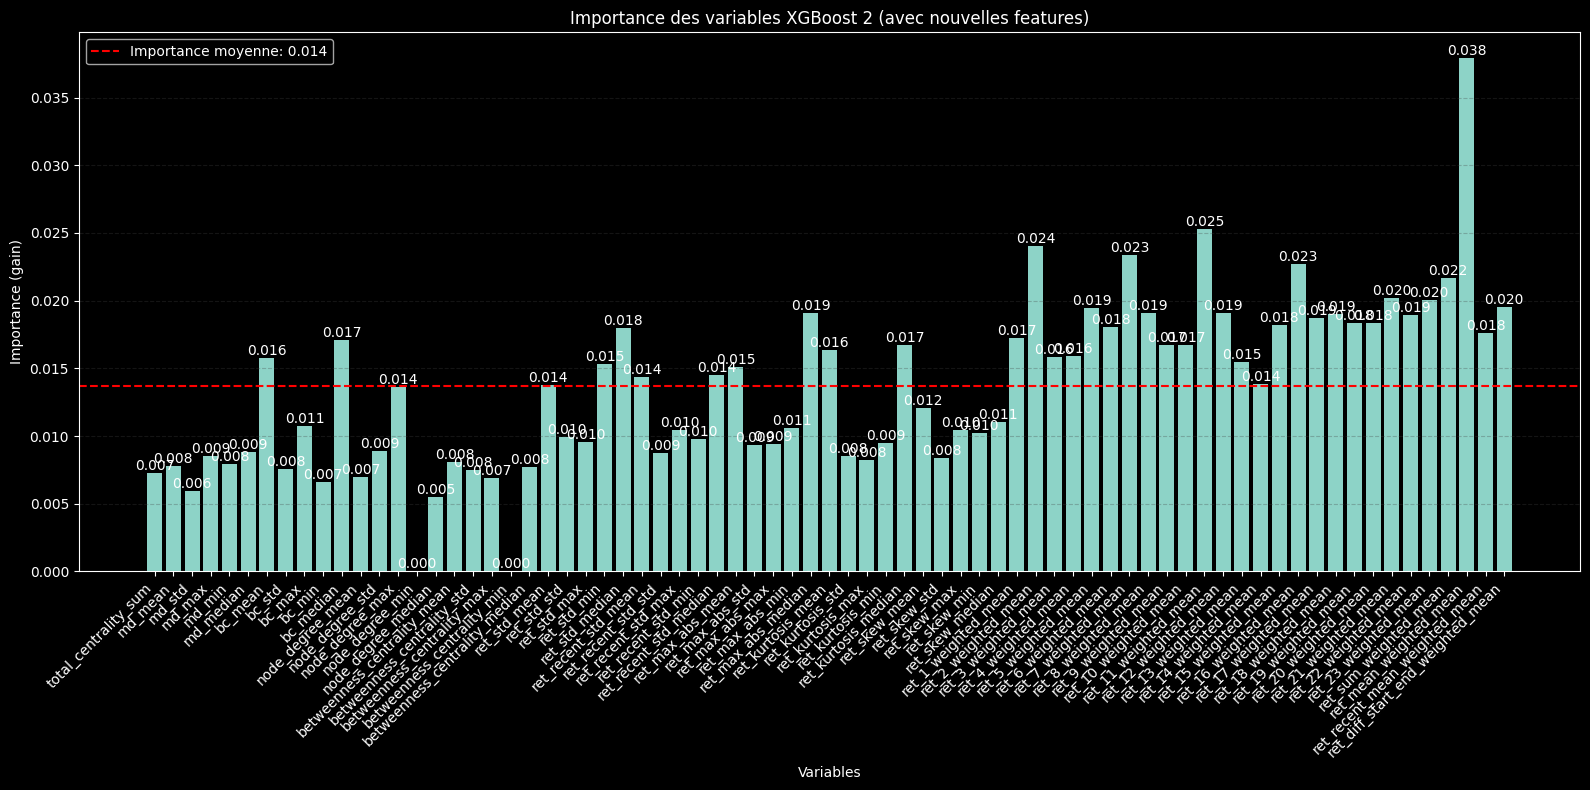

In [ ]:
feature_importances = random_cv.best_estimator_.feature_importances_
features = X.columns

plt.figure(figsize=(16, 8))
bars = plt.bar(features, feature_importances)
plt.title('Importance des variables XGBoost 2')
plt.xlabel('Variables')
plt.ylabel('Importance (gain)')
plt.xticks(rotation=45, ha='right')

mean_importance = np.mean(feature_importances)
plt.axhline(y=mean_importance, color='red', linestyle='--', 
            label=f'Importance moyenne: {mean_importance:.3f}')
plt.legend()
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')

print("----- Résultats du modèle XGBoost -----")
print(f"Meilleur score RMSE: {-random_cv.best_score_:.8f}")
print("Meilleurs paramètres:", random_cv.best_params_)

plt.tight_layout()
plt.show()

In [ ]:
X_test = x_test_final.drop("sample_id", axis=1)
y_pred = random_cv.best_estimator_.predict(X_test)
submission = pd.DataFrame({
    'sample_id': x_test_agg['sample_id'],
    'target': y_pred
})

print("Aperçu du fichier de soumission :")
display(submission.head())

submission.to_csv('output/y_test_XGB2.csv', index=False)

Aperçu du fichier de soumission :


sample_id    target
0      30744 -0.007391
1      30745 -0.002295
2      30746 -0.005463
3      30747 -0.000016
4      30748  0.001708

### 3.4 LightGBM

In [75]:
X = x_train_final.drop(['sample_id'], axis=1)
Y = y_train['target']

model_lgb = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    boosting_type='gbdt',
    random_state=42,
)

param_grid = {
    'num_leaves': [31, 50, 70, 90],
    'max_depth': [-1, 5, 8, 12],
    'learning_rate': [0.03, 0.05, 0.07],
    'n_estimators': [300, 500, 700],
    'min_child_samples': [10, 20, 40],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

cv = TimeSeriesSplit(n_splits=3)

random_lgb = RandomizedSearchCV(
    estimator=model_lgb,
    param_distributions=param_grid,
    n_iter=100,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=0,
    random_state=42
)

random_lgb.fit(X, Y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17040
[LightGBM] [Info] Number of data points in the train set: 7625, number of used features: 71
[LightGBM] [Info] Start training from score 0.000235
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17186
[LightGBM] [Info] Number of data points in the train set: 15248, number of used features: 71
[LightGBM] [Info] Start training from score 0.000101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=LGBMRegressor(metric='rmse',
                                           objective='regression',
                                           random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.9, 1.0],
                                        'learning_rate': [0.03, 0.05, 0.07],
                                        'max_depth': [-1, 5, 8, 12],
                                        'min_child_samples': [10, 20, 40],
                                        'n_estimators': [300, 500, 700],
                                        'num_leaves': [31, 50, 70, 90],
                                        'subsample': [0.7, 0.9, 1.0]},
                   random_state=42, scoring='neg_root_mean_squared_error')

----- Résultats du modèle LightGBM -----
Meilleur score RMSE: 0.00855692
Meilleurs paramètres: {'subsample': 0.7, 'num_leaves': 90, 'n_estimators': 700, 'min_child_samples': 10, 'max_depth': 8, 'learning_rate': 0.07, 'colsample_bytree': 0.7}


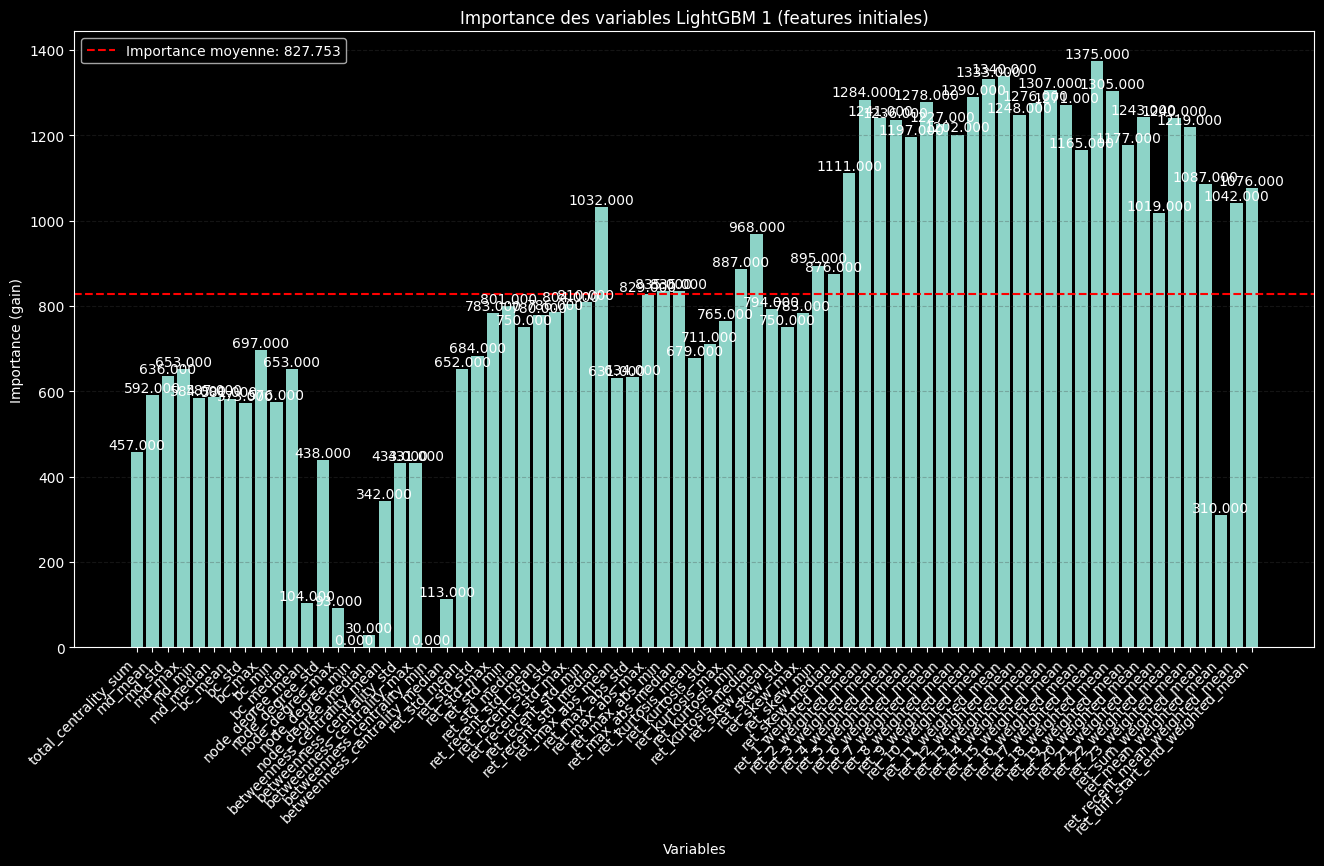

In [ ]:
feature_importances_lgb = random_lgb.best_estimator_.feature_importances_
features = X.columns

plt.figure(figsize=(16, 8))
bars = plt.bar(features, feature_importances_lgb)
plt.title('Importance des variables LightGBM 1')
plt.xlabel('Variables')
plt.ylabel('Importance (gain)')
plt.xticks(rotation=45, ha='right')

mean_importance = np.mean(feature_importances_lgb)
plt.axhline(y=mean_importance, color='red', linestyle='--', 
            label=f'Importance moyenne: {mean_importance:.3f}')
plt.legend()
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')
    
print("----- Résultats du modèle LightGBM -----")
print(f"Meilleur score RMSE: {-random_lgb.best_score_:.8f}")
print("Meilleurs paramètres:", random_lgb.best_params_)

### 3.5 Modèle KNN

In [79]:
X = x_train_final.drop(['sample_id'], axis=1)
Y = y_train['target']


pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(random_state=42)),
    ('knn', KNeighborsRegressor())
])


param_grid_knn_pipeline = {
    # Tuning de l'ACP (choix du nombre de composantes principales)
    'pca__n_components': [10, 20, 30, 40, 50],
    
    # Tuning du KNN
    'knn__n_neighbors': [3, 5, 7, 9, 11],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}


tscv = TimeSeriesSplit(n_splits=3)

random_knn = RandomizedSearchCV(
    estimator=pipeline_knn,
    param_distributions=param_grid_knn_pipeline,
    n_iter=50,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2, 
    random_state=42,
    return_train_score=True
)

random_knn.fit(X, Y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END knn__n_neighbors=7, knn__p=2, knn__weights=uniform, pca__n_components=40; total time=   0.2s
[CV] END knn__n_neighbors=9, knn__p=2, knn__weights=uniform, pca__n_components=10; total time=   0.4s
[CV] END knn__n_neighbors=7, knn__p=2, knn__weights=uniform, pca__n_components=40; total time=   0.4s
[CV] END knn__n_neighbors=9, knn__p=2, knn__weights=uniform, pca__n_components=10; total time=   0.5s
[CV] END knn__n_neighbors=7, knn__p=1, knn__weights=distance, pca__n_components=10; total time=   0.6s
[CV] END knn__n_neighbors=7, knn__p=2, knn__weights=uniform, pca__n_components=40; total time=   0.5s
[CV] END knn__n_neighbors=9, knn__p=2, knn__weights=uniform, pca__n_components=10; total time=   0.6s
[CV] END knn__n_neighbors=11, knn__p=1, knn__weights=uniform, pca__n_components=40; total time=   1.9s
[CV] END knn__n_neighbors=7, knn__p=1, knn__weights=distance, pca__n_components=10; total time=   0.9s
[CV] END knn__n_n

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('pca', PCA(random_state=42)),
                                             ('knn', KNeighborsRegressor())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'knn__n_neighbors': [3, 5, 7, 9, 11],
                                        'knn__p': [1, 2],
                                        'knn__weights': ['uniform', 'distance'],
                                        'pca__n_components': [10, 20, 30, 40,
                                                              50]},
                   random_state=42, return_train_score=True,
                   scoring='neg_root_mean_squared_error', verbose=2)

In [80]:
print("\nOptimisation KNN terminée.")
print("Meilleurs paramètres (Pipeline) :", random_knn.best_params_)
print("Meilleur score (RMSE) :", -random_knn.best_score_)


Optimisation KNN terminée.
Meilleurs paramètres (Pipeline) : {'pca__n_components': 50, 'knn__weights': 'distance', 'knn__p': 1, 'knn__n_neighbors': 3}
Meilleur score (RMSE) : 0.008223794618209013


### 3.6 Métamodèle Stacking Regressor

In [81]:
X = x_train_final.drop(['sample_id'], axis=1)
Y = y_train['target']

xgb_model = xgb.XGBRegressor(
    **random_cv.best_params_,       # hyperparamètres optimisés XGBoost,
    verbosity=0,
    random_state=42
)

lgb_model = lgb.LGBMRegressor(
    **random_lgb.best_params_,      # hyperparamètres optimisés LightGBM
    verbose=-1,
    random_state=42
)

knn_model = random_knn.best_estimator_
    
base_models = [
    ('XGB', xgb_model),
    ('LGB', lgb_model),
    ('KNN', knn_model)
]

stacked_model = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression(),
    n_jobs=-1,
    passthrough=False 
)

stacked_model.fit(X, Y)

StackingRegressor(estimators=[('XGB',
                               XGBRegressor(alpha=0, base_score=None,
                                            booster=None, callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=0,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_con...
                               LGBMRegressor(colsample_bytree=0.7,
                                             learning_rate=0.07, max_depth=8,
                                             min_child_samples=10,
                                             n_estimators=700, num_leaves=90,
                                             random_state=42, subsample=0.7,
                                             verbose=-1)),
                              ('KNN',
                               Pipeline(steps=[('scaler', StandardScaler()),
                                               ('pca',
                                                PCA(n_components=50,
                                                    random_state=42)),
                                               ('knn',
                                                KNeighborsRegressor(n_neighbors=3,
                                                                    p=1,
                                                                    weights='distance'))]))],
                  final_estimator=LinearRegression(), n_jobs=-1)

In [ ]:
submission_preds = stacked_model.predict(x_test_final.drop(['sample_id'], axis=1))
submission = pd.DataFrame({
    'sample_id': x_test_final['sample_id'],
    'target': submission_preds
})

print("Aperçu du fichier de soumission du métamodèle :")
display(submission.head())

submission.to_csv('output/y_test_métamodèle_2.csv', index=False)

Aperçu du fichier de soumission du métamodèle :


sample_id    target
0      30744 -0.008440
1      30745 -0.019290
2      30746 -0.003598
3      30747 -0.000112
4      30748 -0.000527